# Dataset Loading

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)
df.rename(columns={'default payment next month': 'default'}, inplace=True)

print(f"Shape: {df.shape}")
df.head()


Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Data Cleaning

In [3]:
# Drop ID column
df.drop(columns=['ID'], inplace=True)

# Check for nulls / duplicates
print("Null values:\n", df.isna().sum().sum())
print("Duplicates:", df.duplicated().sum())

# Convert categorical columns
df['SEX'] = df['SEX'].map({1:'Male', 2:'Female'})
df['EDUCATION'] = df['EDUCATION'].replace({0:4,5:4,6:4})  # group unknown as 'Other'
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})            # group unknown as 'Other'


Null values:
 0
Duplicates: 35


In [4]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# EDA

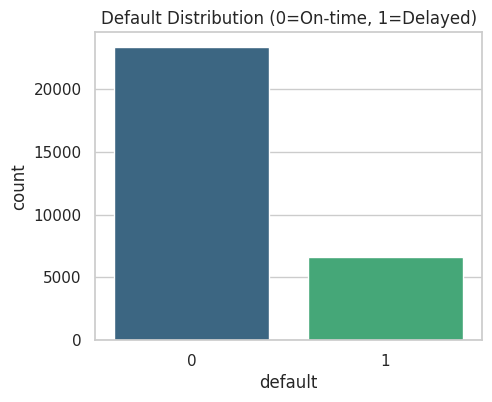

In [5]:
# Default Rate
plt.figure(figsize=(5,4))
sns.countplot(x='default', data=df, palette='viridis')
plt.title("Default Distribution (0=On-time, 1=Delayed)")
plt.show()


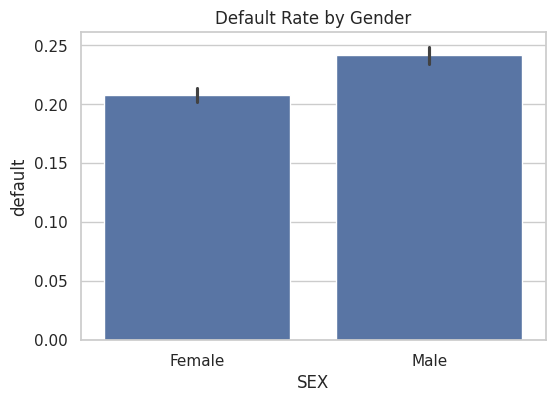

In [6]:
# Gender vs Default
plt.figure(figsize=(6,4))
sns.barplot(x='SEX', y='default', data=df)
plt.title("Default Rate by Gender")
plt.show()

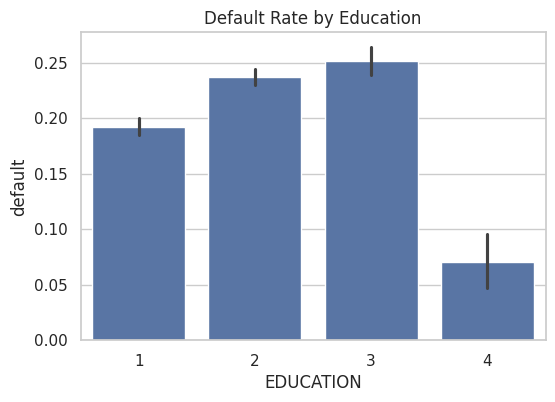

In [7]:
# Education vs Default
plt.figure(figsize=(6,4))
sns.barplot(x='EDUCATION', y='default', data=df)
plt.title("Default Rate by Education")
plt.show()

# Feature Engineering

In [8]:
# Payment history columns (Apr–Sep 2005)
pay_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
pay_amt_cols = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

# Average & volatility of delays
df['avg_payment_delay'] = df[pay_cols].mean(axis=1)
df['max_payment_delay'] = df[pay_cols].max(axis=1)
df['payment_volatility'] = df[pay_cols].std(axis=1)

# Ratio of total payments to total bills
df['payment_ratio'] = df[pay_amt_cols].sum(axis=1) / (df[bill_cols].sum(axis=1)+1)

# Credit utilization (last bill / credit limit)
df['credit_utilization'] = df['BILL_AMT1'] / (df['LIMIT_BAL']+1)

# Trend of payments (improving or worsening)
df['payment_trend'] = df['PAY_0'] - df['PAY_6']

# Visualization

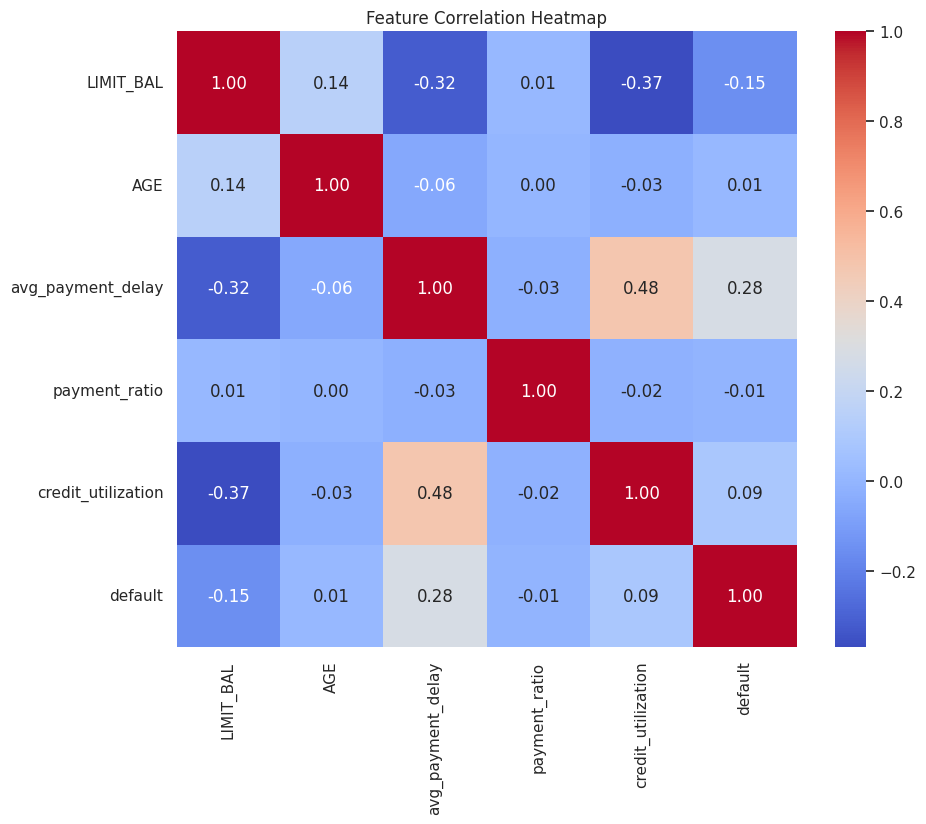

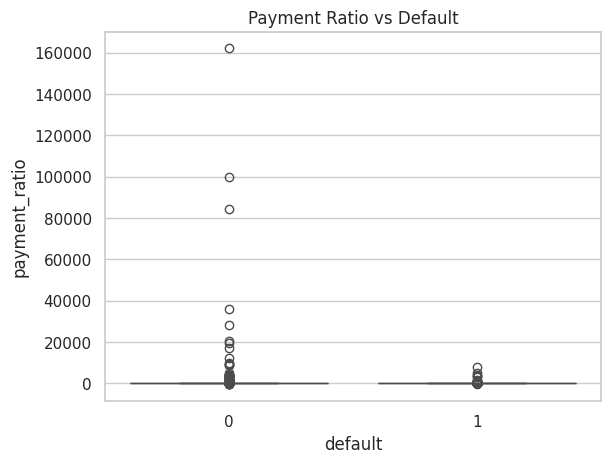

In [9]:
plt.figure(figsize=(10,8))
corr = df[['LIMIT_BAL','AGE','avg_payment_delay','payment_ratio','credit_utilization','default']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

sns.boxplot(x='default', y='payment_ratio', data=df)
plt.title("Payment Ratio vs Default")
plt.show()

In [10]:
df.to_csv("paypredict_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as paypredict_cleaned.csv")

✅ Cleaned dataset saved as paypredict_cleaned.csv


In [11]:
!pip install scikit-learn xgboost shap matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [12]:
df = pd.read_csv("paypredict_cleaned.csv")
print("Shape:", df.shape)
df.head()

Shape: (29965, 30)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,avg_payment_delay,max_payment_delay,payment_volatility,payment_ratio,credit_utilization,payment_trend
0,20000,Female,2,1,24,2,2,-1,-1,-2,...,0,0,0,1,-0.333333,2,1.861899,0.089422,0.195640,4
1,120000,Female,2,2,26,-1,2,0,0,0,...,1000,0,2000,1,0.500000,2,1.224745,0.292774,0.022350,-3
2,90000,Female,2,2,34,0,0,0,0,0,...,1000,1000,5000,0,0.000000,0,0.000000,0.108387,0.324874,0
3,50000,Female,2,1,37,0,0,0,0,0,...,1100,1069,1000,0,0.000000,0,0.000000,0.036259,0.939781,0
4,50000,Male,2,1,57,-1,0,-1,0,0,...,9000,689,679,0,-0.333333,0,0.516398,0.540049,0.172337,-1


# split

In [13]:
X = df.drop(columns=['default'])
y = df['default']

# one-hot encoding
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

In [14]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:,1]

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_prob_log)
print(f"Logistic Regression -> Accuracy: {acc_log:.3f}, ROC-AUC: {auc_log:.3f}")

Logistic Regression -> Accuracy: 0.807, ROC-AUC: 0.735


# XGBOOST

In [15]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print(f"XGBoost -> Accuracy: {acc_xgb:.3f}, ROC-AUC: {auc_xgb:.3f}")

XGBoost -> Accuracy: 0.818, ROC-AUC: 0.778


                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.806775  0.734865
1              XGBoost  0.818121  0.777701


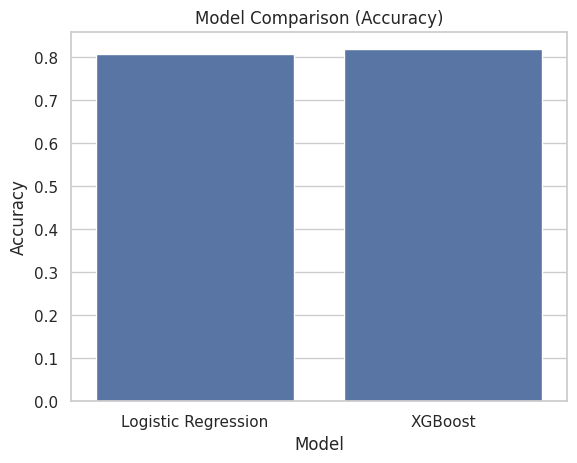

In [16]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [acc_log, acc_xgb],
    'ROC-AUC': [auc_log, auc_xgb]
})
print(results)
sns.barplot(data=results, x='Model', y='Accuracy')
plt.title("Model Comparison (Accuracy)")
plt.show()


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4667
           1       0.66      0.36      0.47      1326

    accuracy                           0.82      5993
   macro avg       0.75      0.65      0.68      5993
weighted avg       0.80      0.82      0.80      5993



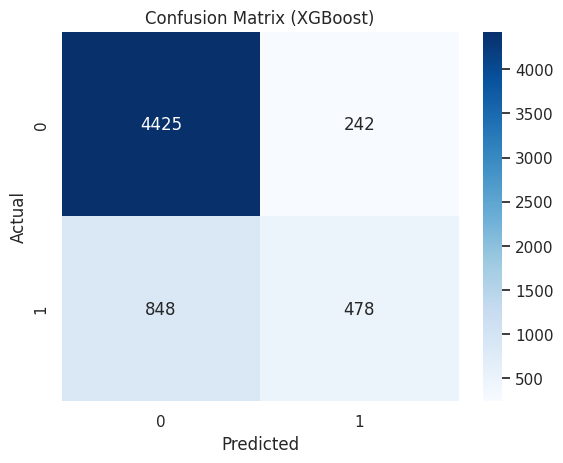

In [17]:
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

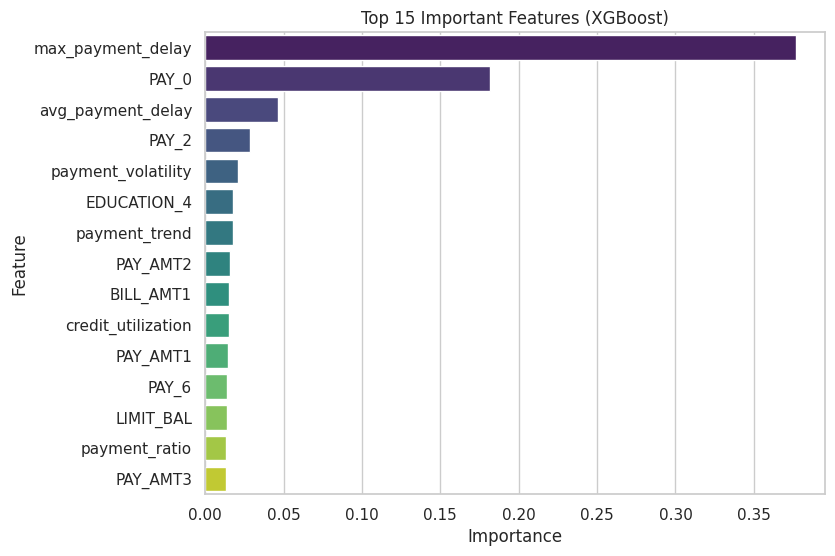

In [18]:
importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Important Features (XGBoost)")
plt.show()


#Finetuning

Dataset shape after removing duplicates: (29965, 30)
Before SMOTE: {0: 18668, 1: 5304}
After SMOTE:  {0: 18668, 1: 18668}

✅ Fusion Model Accuracy: 0.807
✅ Fusion Model ROC-AUC : 0.766

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4667
           1       0.59      0.41      0.49      1326

    accuracy                           0.81      5993
   macro avg       0.72      0.67      0.68      5993
weighted avg       0.79      0.81      0.79      5993


🔍 Generating SHAP values (this may take a moment)...


PermutationExplainer explainer: 5994it [1:42:30,  1.03s/it]


✅ SHAP values generated successfully!


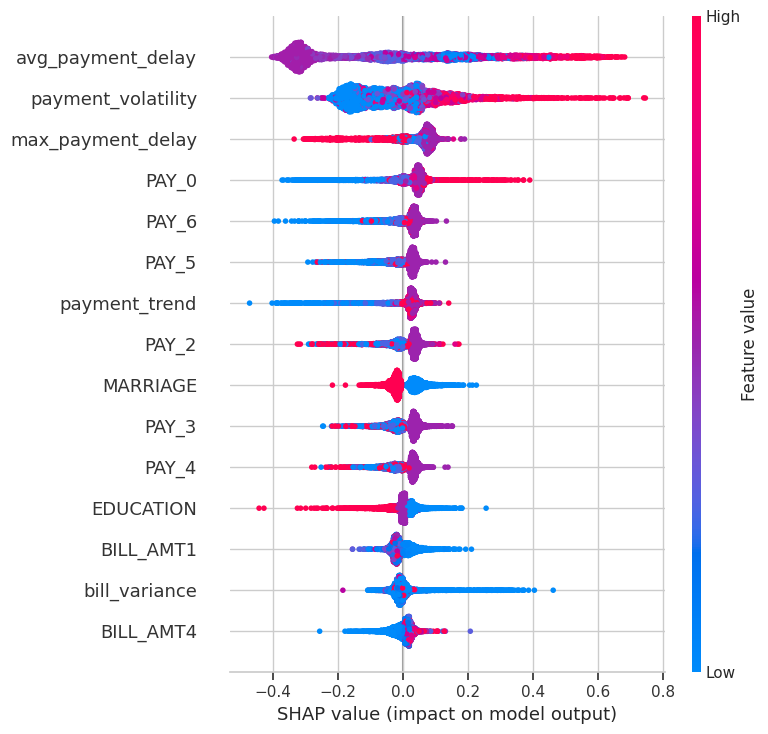


💾 Model saved as paypredict_fusion_model.pkl


In [19]:
!pip install xgboost shap imbalanced-learn scikit-learn -q

import numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
import joblib, warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("paypredict_cleaned.csv").drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")

# Encode categorical columns numerically
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes


df['avg_bill_amt'] = df[[f'BILL_AMT{i}' for i in range(1,7)]].mean(axis=1)
df['avg_pay_amt'] = df[[f'PAY_AMT{i}' for i in range(1,7)]].mean(axis=1)
df['payment_ratio'] = df['avg_pay_amt'] / (df['avg_bill_amt'] + 1)
df['bill_variance'] = df[[f'BILL_AMT{i}' for i in range(1,7)]].var(axis=1)
df['utilization'] = df['avg_bill_amt'] / (df['LIMIT_BAL'] + 1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

X = df.drop(columns=['default'])
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE:  {pd.Series(y_res).value_counts().to_dict()}")

xgb_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=2,
    gamma=0.2,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1,
    reg_alpha=0.1,
    eval_metric='auc',
    random_state=42
)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
log_model = LogisticRegression(max_iter=500)

fusion_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('lr', log_model)],
    voting='soft'
)


fusion_model.fit(X_res, y_res)
xgb_model.fit(X_res, y_res)  # Train separately for SHAP explainability

y_pred = fusion_model.predict(X_test)
y_prob = fusion_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\n✅ Fusion Model Accuracy: {acc:.3f}")
print(f"✅ Fusion Model ROC-AUC : {auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\n🔍 Generating SHAP values (this may take a moment)...")

explainer = shap.Explainer(xgb_model.predict, X_test, feature_names=X.columns)
shap_values = explainer(X_test)

print("✅ SHAP values generated successfully!")

shap.summary_plot(shap_values.values, X_test, feature_names=X.columns, max_display=15)

joblib.dump(fusion_model, "paypredict_fusion_model.pkl")
print("\n💾 Model saved as paypredict_fusion_model.pkl")
